<a href="https://colab.research.google.com/github/C-Designer/Codestates_Section_Project/blob/main/Section2/Section2_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [227]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [228]:
!pip install -U pandas-profiling
!pip install category_encoders
!pip install pdpbox
!pip install shap

Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.7/dist-packages (2.11.0)


In [229]:
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pdpbox.pdp import pdp_interact, pdp_interact_plot
from sklearn.model_selection import train_test_split
from category_encoders import OrdinalEncoder
from pdpbox.pdp import pdp_isolate, pdp_plot
from pandas_profiling import ProfileReport
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

# Dataset : Deep Scapula (견갑골 심부구조)
source : https://www.kaggle.com/iham97/deepscapulassm?select=scapFeaturesUnif_3.csv

#### 견관절부의 주요 질환들을 가장 예측하기 좋은 지표는 CSA(임계 어깨 각도)다

## 스토리텔링
1. 대한의료 정보학회에 데이터 사이언티스트로 근무

2. 견갑골 구조를 분석하여 CSA(임계 어깨 각도)수치를 예측<br>
이후 CSA를 통해 RCI(회전근계 파열)또는 GH joint OA(견관절염) 주의 환자임을 파악해야함

- normal range: 30-35 degrees
- increased CSA: > 35°
  - associated with rotator cuff tears of the shoulder
  - sensitivity 82%; specificity 92%
- decreased CSA: < 30°
  - associated with primary concentric glenohumeral osteoarthritis
  - sensitivity 78%; specificity of 97%

<br>

CSA란? : https://radiopaedia.org/articles/critical-shoulder-angle

CSA와 RCI의 상관관계 분석 : https://www.scielo.br/scielo.php?script=sci_arttext&pid=S0102-36162017000400423

견관절부 주요질환 파악에 가장좋은 지표 - CSA : https://bmcmusculoskeletdisord.biomedcentral.com/articles/10.1186/s12891-017-1559-4

In [230]:
df = pd.read_csv('/content/drive/MyDrive/Data Storage/scapFeaturesGauss1_5.csv').iloc[:, 1:12]
df

,CSA,Version,Tilt,Glene Width,Glene Length,Scapula Length,Spine Length,Lat Acromion Angle,Glene Radius,Acromion Shape,Tilt Class
0,35.377494,14.893928,7.700076,24.500691,27.317544,145.339661,134.368393,92.145481,21.871616,1.0,2.0
1,41.238047,9.521284,0.835240,23.780445,35.993161,133.789950,156.821989,97.720930,33.551018,2.0,2.0
2,43.131545,22.434351,25.815892,23.259885,24.567649,123.298976,115.796984,105.685891,20.319127,2.0,2.0
3,25.095480,5.012612,5.640584,29.324090,38.052437,167.421398,143.476972,86.946494,37.621337,2.0,2.0
4,26.290516,5.908531,-1.585274,25.558747,38.942607,163.320756,142.726150,87.366569,38.682884,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
99995,23.108040,-1.986798,-4.001290,21.727007,40.670487,149.754562,138.783717,81.012235,49.572211,2.0,1.0
99996,42.244779,16.983629,10.835220,26.168241,39.389867,177.266484,162.806064,96.959277,25.493845,2.0,2.0
99997,16.448685,3.824296,9.878742,26.307192,33.972964,160.369085,120.473792,61.237730,33.025393,3.0,2.0
99998,25.917182,0.828885,8.055708,28.099462,37.616592,187.296428,136.919227,68.429528,36.212876,2.0,2.0


# EDA

In [231]:
# df.profile_report().to_notebook_iframe()

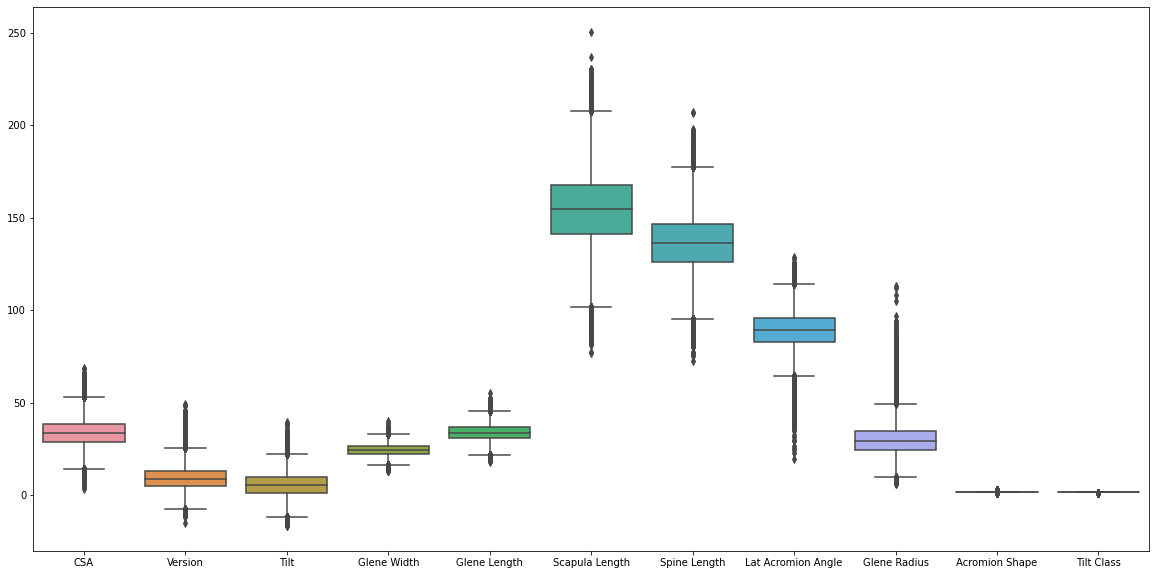

In [232]:
# Outlier

plt.figure(figsize= [20, 10])
sns.boxplot(data=df, )

In [233]:
df.isna().sum()

CSA                   0
Version               0
Tilt                  0
Glene Width           0
Glene Length          0
Scapula Length        0
Spine Length          0
Lat Acromion Angle    0
Glene Radius          0
Acromion Shape        0
Tilt Class            0
dtype: int64

In [234]:
df.describe()

,CSA,Version,Tilt,Glene Width,Glene Length,Scapula Length,Spine Length,Lat Acromion Angle,Glene Radius,Acromion Shape,Tilt Class
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000
mean,33.830566,9.561111,5.621756,24.671350,33.834401,154.620458,136.493451,89.009871,30.182140,2.04294,1.810180
std,7.242213,6.379106,6.393997,3.118340,4.342510,19.480935,15.205280,9.776468,8.284924,0.36188,0.392161
min,3.256300,-15.213445,-16.628307,13.024653,18.263390,77.013210,72.560832,19.578528,5.870900,1.00000,1.000000
25%,28.911699,5.138617,1.202943,22.544308,30.828365,141.427860,126.215867,83.052879,24.664689,2.00000,2.000000
50%,33.697017,9.049340,5.325808,24.641797,33.710622,154.596913,136.509038,89.508890,29.233715,2.00000,2.000000
75%,38.600019,13.392462,9.683547,26.753020,36.712499,167.831373,146.707513,95.518573,34.635581,2.00000,2.000000
max,68.581035,49.208023,39.541858,40.308721,55.133939,250.337999,207.331906,128.482970,113.331020,3.00000,2.000000


In [235]:
df.dtypes

CSA                   float64
Version               float64
Tilt                  float64
Glene Width           float64
Glene Length          float64
Scapula Length        float64
Spine Length          float64
Lat Acromion Angle    float64
Glene Radius          float64
Acromion Shape        float64
Tilt Class            float64
dtype: object

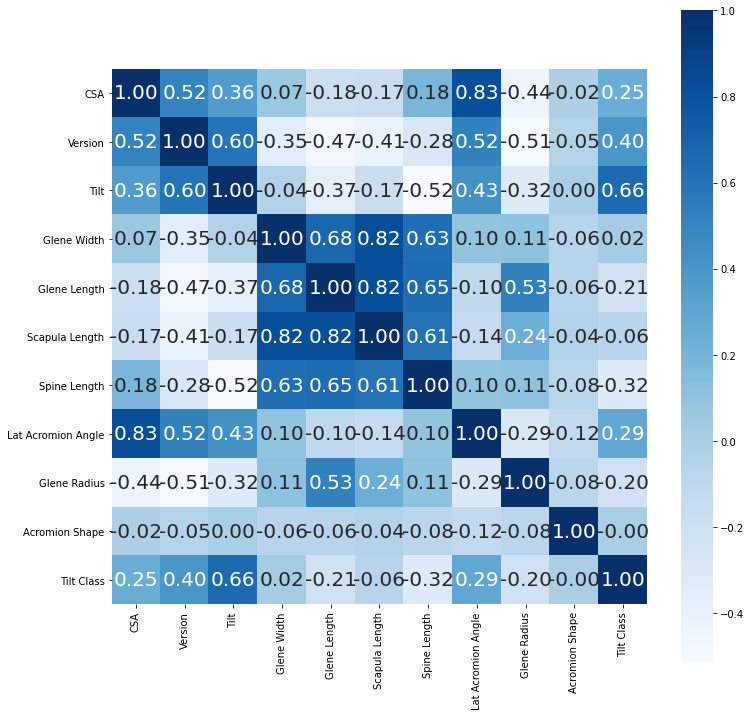

In [236]:
corr = df.corr(method= 'pearson')

plt.figure(figsize= [12, 12])
sns.heatmap(corr, cbar = True, annot = True, annot_kws={'size' : 20}, fmt = '.2f', square = True, cmap = 'Blues')

## Features
- CSA : Critical Shoulder Angle (임계어깨 각도) **[target]**
- Version : Glenoid Version Angle (날개뼈 내측끝과 견봉돌기를 선으로 연결하여 수직의 선을 그린뒤 관절와 좌우끝과 연결한 선의 각도)
- Tilt : 해당 모형의 날개뼈 tilting 각도
- Glene Width, Length, Radius : Glenoid의 높이, 너비, 반지름 (mm)
- Scapula, Spine Length : 날개뼈의 길이(mm), 척주뼈의 길이(cm)
- Lat Acromion Angle : Lat = Lateral, 측면 견봉각도
- Acromion Shape : 견봉의 형태 (3가지로 분류)
- Tilt Class : 날개뼈가 전방경사 or 후방경사

### What is Glenoid? 
우리의 팔(상완골두)이 어깨와 붙어있는 지점 (오목한 형태) 

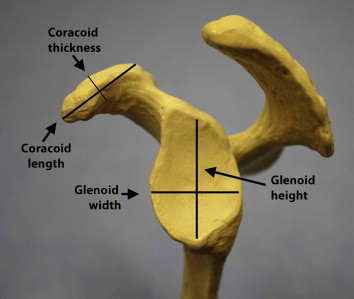

### What is CSA?

Glenoid를 위사진과 달리 정면이 아닌 측면에서 보았을때

Glenoid height 기준선을 따라 선을긋고 Acromion 측면끝과 Glenoid하단부와 연결한 선 사이의 각도

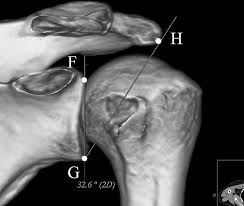

### Lateral Acromion Angle (LAA)
CSA와 밀접한 관계를 보이는 LAA<br>
임계각을 구하는 기준들이 CSA와 근접하거나 중복되어 있는 것으로 확인됨

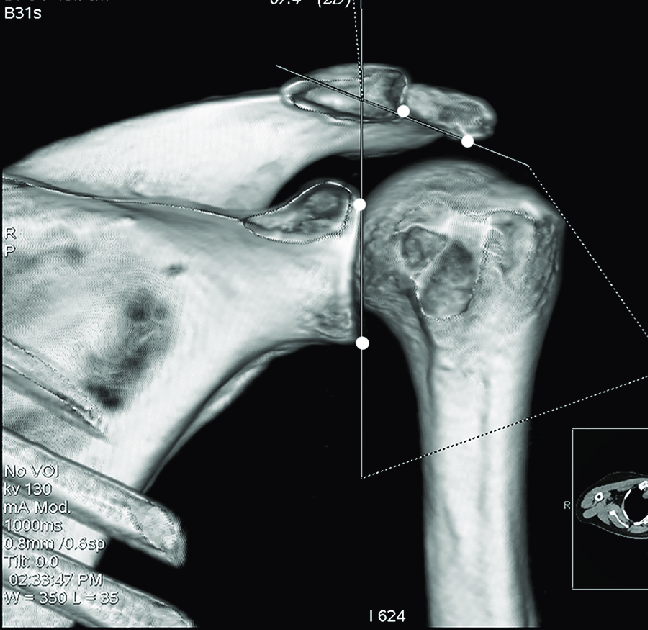


### Version : 날개뼈 내측끝과 견봉돌기를 선으로 연결하여 수직의 선을 그린뒤 관절와 좌우끝과 연결한 선의 각도

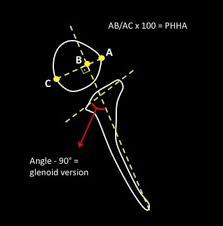

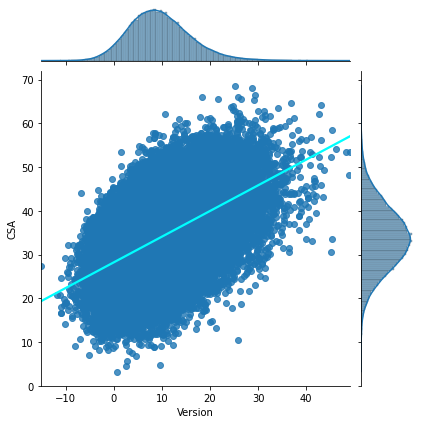

In [237]:
# Version과 CSA는 양의 관계를 가지는 것으로 보인다

sns.jointplot(x="Version", y="CSA", data=df, kind='reg',
                  joint_kws={'line_kws':{'color':'cyan'}})

### Tilt, Tilt Class

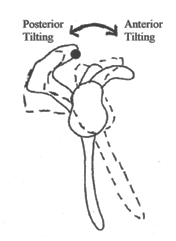

link : http://www.koreascience.kr/article/CFKO200909659873588.pdf

Saha 에 따르면 환자의75%가 평균 7도의 후방 경사가 있고, 25%의 환자에서는 2~10도의 전방 경사가 있다고 하였다

([<matplotlib.patches.Wedge at 0x7fdb22ffd5d0>,
 [Text(-0.45034786768868174, 1.0035869658720453, '2.0'),
  Text(0.4503478207073848, -1.0035869869543492, '1.0')],
 [Text(-0.24564429146655364, 0.5474110722938428, '81.0%'),
  Text(0.2456442658403917, -0.5474110837932814, '19.0%')])

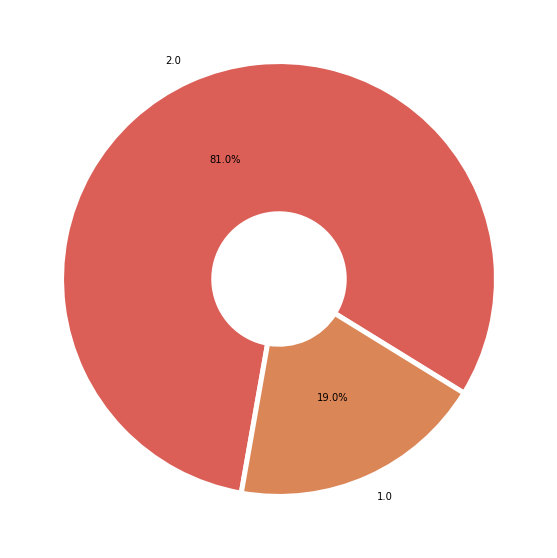

In [238]:
# 클래스의 비율
colors = sns.color_palette('hls', 20) #색상 지정

tilt_ratio = df['Tilt Class'].value_counts(normalize= True)
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

plt.figure(figsize= [15, 10])
plt.pie(tilt_ratio , labels= tilt_ratio.index, autopct='%.1f%%', startangle=260, counterclock=False, colors=colors, wedgeprops=wedgeprops)

In [239]:
# tilt class가 1일때 Anterior(전방 경사), 2일때 Posterior(후방 경사)

df[['Tilt', 'Tilt Class']].groupby(['Tilt Class']).mean()

,Tilt
Tilt Class,
1.0,-3.082486
2.0,7.661105


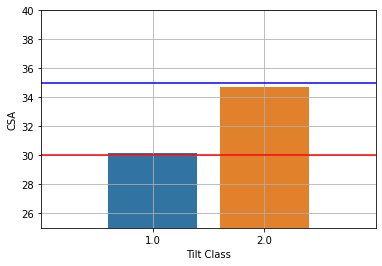

In [240]:
# 평균적으로 전방경사일 경우 견관절염, 후방경사일 경우 회전근개 파열 위험

class_mean = df[['CSA', 'Tilt Class']].groupby(['Tilt Class']).mean().reset_index()

sns.barplot(data=class_mean, x= 'Tilt Class', y= 'CSA')

plt.axis([-1 , 2, 25, 40]) # x축 시작값, x축 끝값, y축 시작값, y축 끝값
plt.axhline(y=30 , xmin=0, xmax= 1, color= 'red') # 빨간선 견관절염
plt.axhline(y=35 , xmin=0, xmax= 1, color= 'blue') # 파란선 회전근개 파열

plt.grid()
plt.show()

## Feature Engineering of Length

사람마다 골격구조의 크기비율은 다 다르다
그 비율과 CSA의 상관관계를 알아보고 싶다 (mm 기준)

- 날개뼈와 척주
- 날개뼈와 Glenoid 너비, 높이, 반지름
- Version을 활용한 특성추출

In [241]:
# 날개뼈(Scapula), 척주(Spine)

df['spine_scapula'] = (df['Spine Length'] * 10) / df['Scapula Length']
df['scapula_spine'] = df['Scapula Length'] / (df['Spine Length'] * 10)

# 날개뼈와 Glenoid 관련 수치

df['width_scapula'] = df['Glene Width'] / df['Scapula Length']
df['scapula_width'] = df['Scapula Length'] / df['Glene Width']
# df['glene_scapula'] = df['Glene Length'] / df['Scapula Length']
# df['scapula_glene'] = df['Scapula Length'] / df['Glene Length']
df['radius_scapula'] = df['Glene Radius'] / df['Scapula Length']
df['scapula_radius'] = df['Scapula Length'] / df['Glene Radius']

# Glenoid 너비와 높이

df['width_length'] = df['Glene Width'] / df['Glene Length']
df['length_width'] = df['Glene Length'] / df['Glene Width']

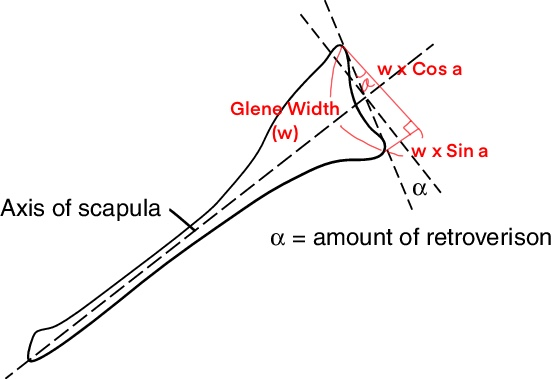

In [242]:
# Version을 이용하여 특성값 추출 / Version= a
# 모든 Feature들과 상관계수가 너무 낮게 측정됨

# df['cos'] = df['Version'].apply(math.cos) * df['Glene Width']
# df['sin'] = df['Version'].apply(math.sin) * df['Glene Width']

# df['cos_width'] = df['cos'] / df['Glene Width']
# df['width_cos'] = df['Glene Width'] / df['cos']

# df['sin_width'] = df['sin'] / df['Glene Width']
# df['width_sin'] = df['Glene Width'] / df['sin']

# df['cos__width'] = df['cos'] * df['Glene Width']
# df['width__cos'] = df['Glene Width'] * df['cos']

# df['sin__width'] = df['sin'] * df['Glene Width']
# df['width__sin'] = df['Glene Width'] * df['sin']

# df['cos_scapula'] = df['cos'] / df['Scapula Length']
# df['scapula_cos'] = df['Scapula Length'] / df['cos']

# df['sin_scapula'] = df['sin'] / df['Scapula Length']
# df['scapula_sin'] = df['Scapula Length'] / df['sin']

# df['sin_cos'] = df['sin'] / df['cos']
# df['cos_sin'] = df['cos'] / df['sin']

# df['triangle_1'] = (df['Scapula Length'] + df['sin']) * df['cos'] / 2
# df['triangle_2'] = (df['Scapula Length'] + (df['sin'] / 2)) * df['cos'] / 2
# df['triangle_3'] = df['Scapula Length'] * df['cos'] / 2

## Feature Engineering of Angle

개개인의 각도를 기준하여 조립해본 특성

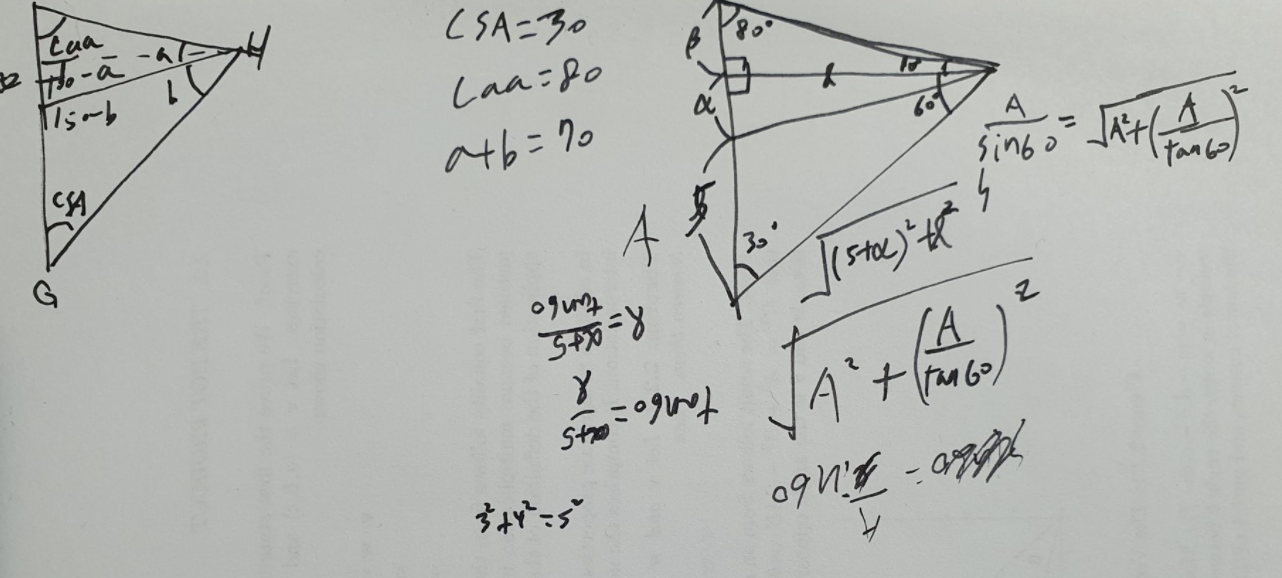

In [243]:
# 항등식을 두고 방정식처럼 풀려했다..

from sympy import Symbol, solve

x = Symbol('x')

eq1 = x / math.sin(60)
eq2 = (x**2 + (x / math.tan(60))**2) **0.5

solve((eq1, eq2), dict= True)

[{x: 0.0}]

In [244]:
# 상관 관계가 높은 Version, LAA, Tilt / 상관관계가 낮은특성 제거
# 길이간 비율과 달리 각도를 가지고 무작정 때려넣으니 아무런 효용이 없었다. (섞은 Feature들보다 더 높은 상관관계는 없었다)

df['Version_LAA'] = df['Version'] / df['Lat Acromion Angle']
# df['LAA_Version'] = df['Lat Acromion Angle'] / df['Version']
 
# df['90_Version_LAA'] = (90 - df['Version']) / df['Lat Acromion Angle']
df['90_LAA_Version'] = df['Lat Acromion Angle']** 3 / ((90 - df['Version']) ** 0.1)

#df['Version_Tilt'] = df['Version'] / df['Tilt']
#df['Tilt_Version'] = df['Tilt'] / df['Version']

#df['90_Version_Tilt'] = (90 - df['Version']) / df['Tilt']
df['90_Tilt_Version'] = df['Tilt']**0.001 / (90 - df['Version'])

# df['LAA_Tilt'] = df['Lat Acromion Angle'] / df['Tilt']
# df['Tilt_LAA'] = df['Tilt'] / df['Lat Acromion Angle']

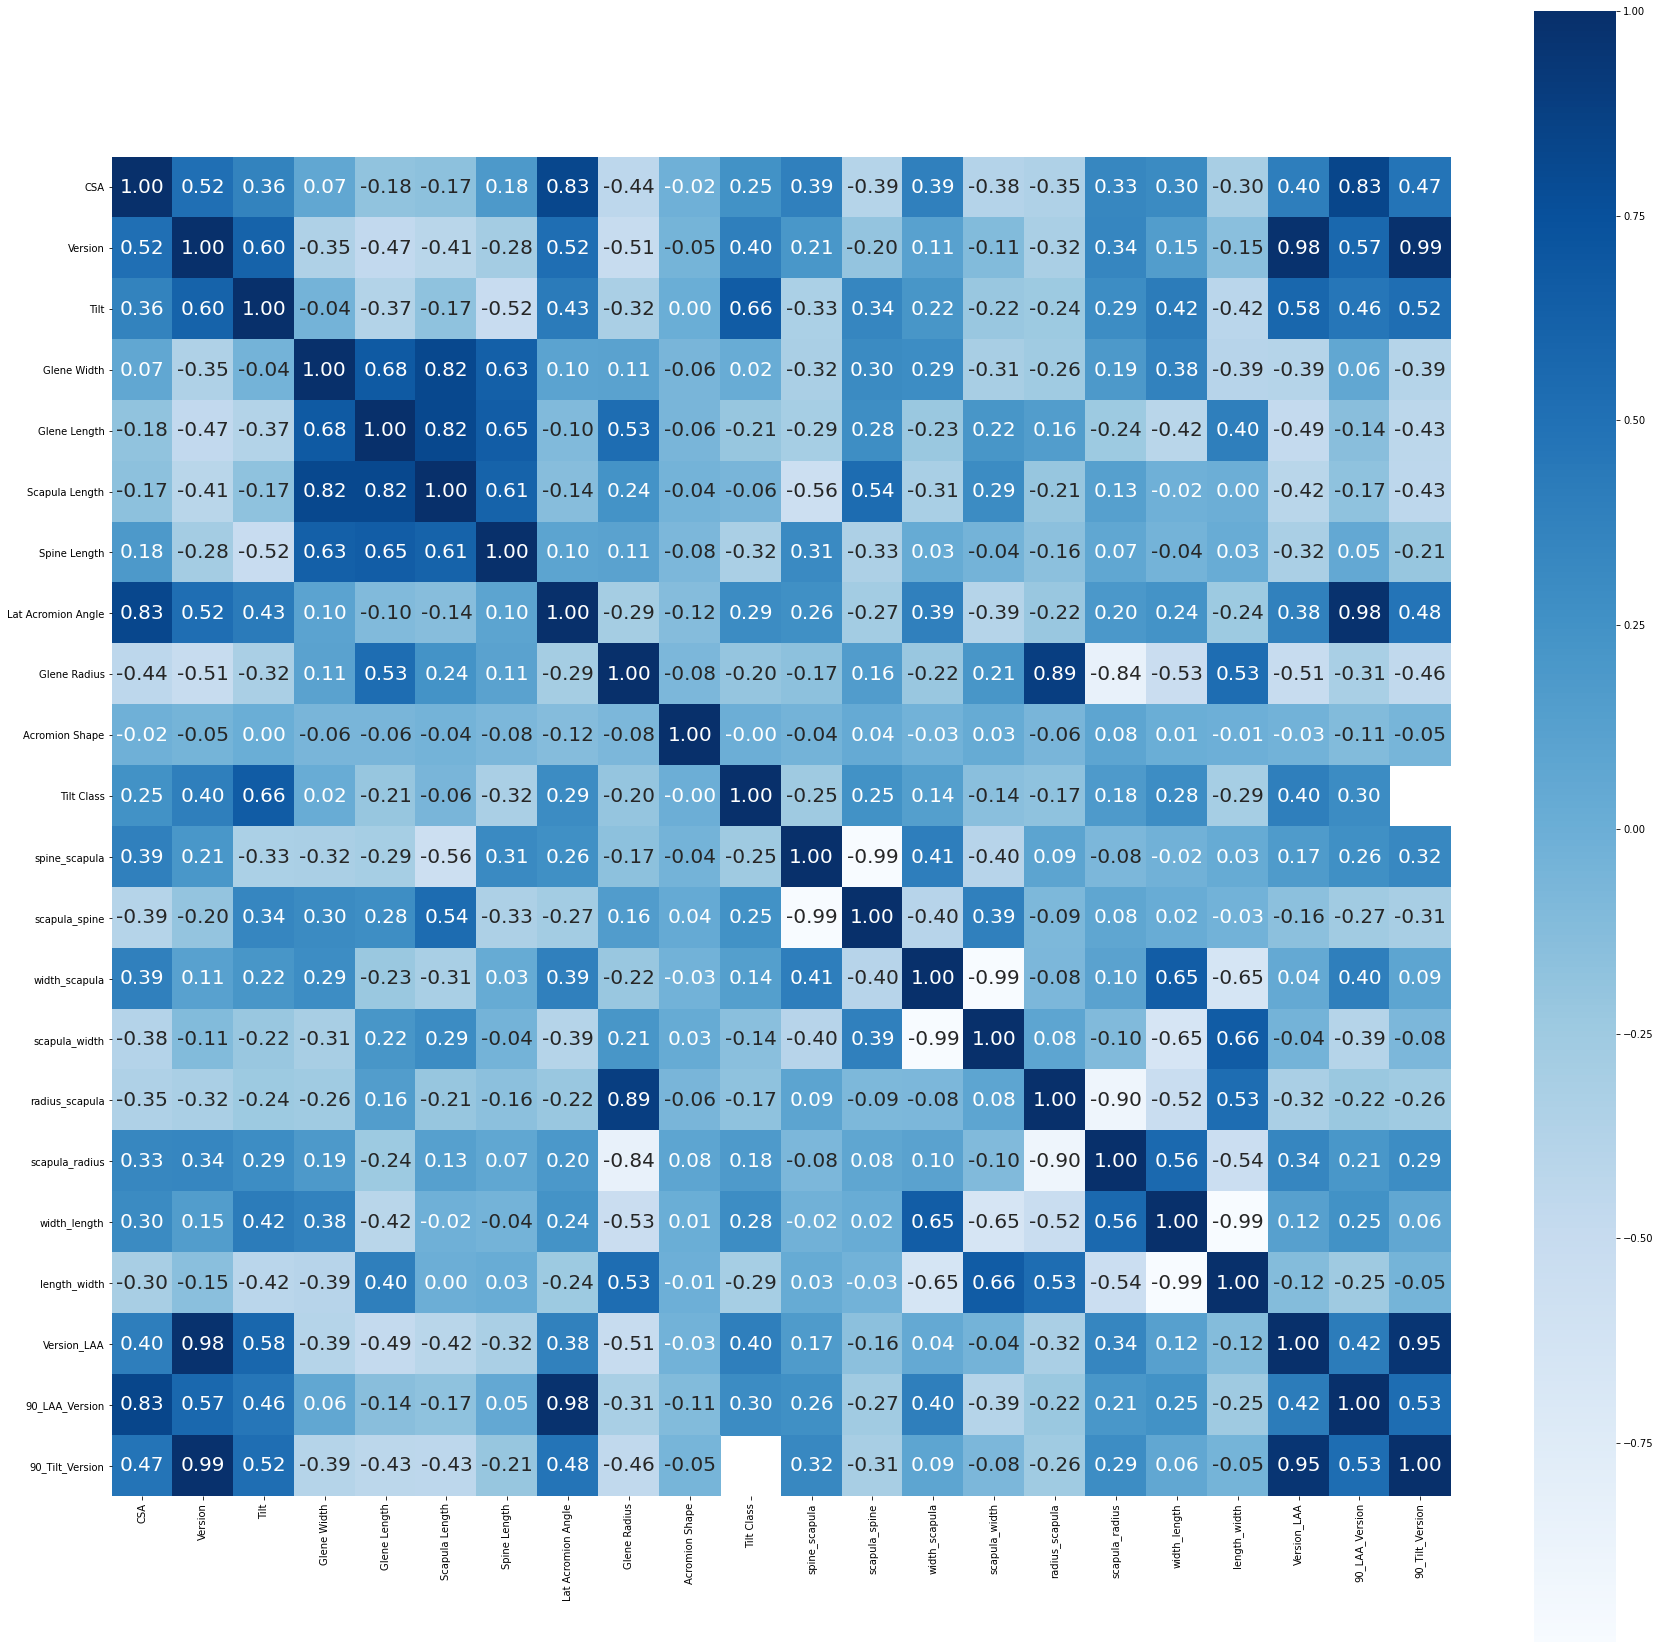

In [245]:
corr = df.corr(method= 'pearson')

plt.figure(figsize= [30, 30])
sns.heatmap(corr, cbar = True, annot = True, annot_kws={'size' : 20}, fmt = '.2f', square = True, cmap = 'Blues')

In [246]:
# 범주형 타겟 추출

bins = [0, 30, 35, 100]
bins_label= ['RCI', 'Normal', 'OA', '?']

df["CSA_category"] = pd.cut(df["CSA"], bins, right=False, labels=bins_label[:-1])

df

,CSA,Version,Tilt,Glene Width,Glene Length,Scapula Length,Spine Length,Lat Acromion Angle,Glene Radius,Acromion Shape,Tilt Class,spine_scapula,scapula_spine,width_scapula,scapula_width,radius_scapula,scapula_radius,width_length,length_width,Version_LAA,90_LAA_Version,90_Tilt_Version,CSA_category
0,35.377494,14.893928,7.700076,24.500691,27.317544,145.339661,134.368393,92.145481,21.871616,1.0,2.0,9.245129,0.108165,0.168575,5.932064,0.150486,6.645127,0.896885,1.114970,0.161635,507989.361675,0.013342,OA
1,41.238047,9.521284,0.835240,23.780445,35.993161,133.789950,156.821989,97.720930,33.551018,2.0,2.0,11.721507,0.085313,0.177745,5.626049,0.250774,3.987657,0.660693,1.513561,0.097433,601720.305034,0.012423,OA
2,43.131545,22.434351,25.815892,23.259885,24.567649,123.298976,115.796984,105.685891,20.319127,2.0,2.0,9.391561,0.106479,0.188646,5.300928,0.164796,6.068124,0.946769,1.056224,0.212274,774601.697344,0.014849,OA
3,25.095480,5.012612,5.640584,29.324090,38.052437,167.421398,143.476972,86.946494,37.621337,2.0,2.0,8.569811,0.116689,0.175151,5.709347,0.224710,4.450171,0.770623,1.297651,0.057652,421522.515628,0.011787,RCI
4,26.290516,5.908531,-1.585274,25.558747,38.942607,163.320756,142.726150,87.366569,38.682884,2.0,1.0,8.739009,0.114429,0.156494,6.390014,0.236852,4.222042,0.656318,1.523651,0.067629,428115.195581,NaN,RCI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,23.108040,-1.986798,-4.001290,21.727007,40.670487,149.754562,138.783717,81.012235,49.572211,2.0,1.0,9.267412,0.107905,0.145084,6.892554,0.331023,3.020938,0.534220,1.871886,-0.024525,338282.312813,NaN,RCI
99996,42.244779,16.983629,10.835220,26.168241,39.389867,177.266484,162.806064,96.959277,25.493845,2.0,2.0,9.184255,0.108882,0.147621,6.774108,0.143816,6.953305,0.664339,1.505255,0.175162,593507.330073,0.013728,OA
99997,16.448685,3.824296,9.878742,26.307192,33.972964,160.369085,120.473792,61.237730,33.025393,3.0,2.0,7.512283,0.133115,0.164042,6.096017,0.205934,4.855933,0.774357,1.291395,0.062450,147068.199219,0.011631,RCI
99998,25.917182,0.828885,8.055708,28.099462,37.616592,187.296428,136.919227,68.429528,36.212876,2.0,2.0,7.310296,0.136793,0.150027,6.665481,0.193345,5.172095,0.746996,1.338694,0.012113,204507.019978,0.011238,RCI


In [247]:
# Hold Out CV

X = df.drop(columns=['CSA', 'CSA_category'])
y = df[['CSA', 'CSA_category']]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=1)

print("Train : ",X_train.shape,y_train.shape)
print("Val : ",X_val.shape,y_val.shape)
print("Test : ",X_test.shape,y_test.shape)

Train :  (60000, 21) (60000, 2)
Val :  (20000, 21) (20000, 2)
Test :  (20000, 21) (20000, 2)
